## Import libraries 

In [1]:
import nltk
nltk.download('punkt')
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from nltk.corpus import wordnet
from nltk import pos_tag
import re
from collections import OrderedDict
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import unicodedata, re, string
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Import dataset

In [2]:
# displaying the entire dataset
total = pd.read_csv('Restaurant_Reviews.tsv',delimiter='\t',quoting=3)
print(total)

                                                Review  Liked
0                             Wow... Loved this place.      1
1                                   Crust is not good.      0
2            Not tasty and the texture was just nasty.      0
3    Stopped by during the late May bank holiday of...      1
4    The selection on the menu was great and so wer...      1
..                                                 ...    ...
995  I think food should have flavor and texture an...      0
996                           Appetite instantly gone.      0
997  Overall I was not impressed and would not go b...      0
998  The whole experience was underwhelming, and I ...      0
999  Then, as if I hadn't wasted enough of my life ...      0

[1000 rows x 2 columns]


In [3]:
# using pandas library function groupby() to split the dataset into groups here based on 'review'
# and return aggregated value for each group by using a lambda function
total = total.groupby('Review').agg(lambda x: x.tolist())
total = total.reset_index()
print(total)

                                                Review Liked
0    !....THE OWNERS REALLY REALLY need to quit bei...   [0]
1    (It wasn't busy either) Also, the building was...   [0]
2      (The bathroom is just next door and very nice.)   [1]
3    * Both the Hot & Sour & the Egg Flower Soups w...   [1]
4            - Really, really good rice, all the time.   [1]
..                                                 ...   ...
991        very slow at seating even with reservation.   [0]
992               very tough and very short on flavor!   [0]
993  walked in and the place smelled like an old gr...   [0]
994                           will definitely be back!   [1]
995  you can watch them preparing the delicious food!)   [1]

[996 rows x 2 columns]


### Create a list with reviews in column-index 0 and Liked in column-index 1

In [4]:
total_text = list()
for lists in total.values:
  combines_text = ''
  for _ in lists[0]:
    combines_text = combines_text + _
  total_text.append([combines_text, lists[1][0]])
#total_text
total_text = pd.DataFrame(total_text)
print(total_text)

                                                     0  1
0    !....THE OWNERS REALLY REALLY need to quit bei...  0
1    (It wasn't busy either) Also, the building was...  0
2      (The bathroom is just next door and very nice.)  1
3    * Both the Hot & Sour & the Egg Flower Soups w...  1
4            - Really, really good rice, all the time.  1
..                                                 ... ..
991        very slow at seating even with reservation.  0
992               very tough and very short on flavor!  0
993  walked in and the place smelled like an old gr...  0
994                           will definitely be back!  1
995  you can watch them preparing the delicious food!)  1

[996 rows x 2 columns]


## Isolating the positive reviews

In [5]:
total_positive = total_text.copy()
total_positive.columns
total_positive = total_positive.loc[total_positive[1] == 1]
print(total_positive)

                                                     0  1
2      (The bathroom is just next door and very nice.)  1
3    * Both the Hot & Sour & the Egg Flower Soups w...  1
4            - Really, really good rice, all the time.  1
6             - the food is rich so order accordingly.  1
9                                        2 Thumbs Up!!  1
..                                                 ... ..
986  the staff is friendly and the joint is always ...  1
988                                this place is good.  1
989  this was a different cut than the piece the ot...  1
994                           will definitely be back!  1
995  you can watch them preparing the delicious food!)  1

[499 rows x 2 columns]


## Isolating negative reviews

In [6]:
total_negative = total_text.copy()
total_negative.columns
total_negative = total_negative.loc[total_negative[1] == 0]
print(total_negative)

                                                     0  1
0    !....THE OWNERS REALLY REALLY need to quit bei...  0
1    (It wasn't busy either) Also, the building was...  0
5           - They never brought a salad we asked for.  0
7    -Drinks took close to 30 minutes to come out a...  0
8                           -My order was not correct.  0
..                                                 ... ..
987  this is the worst sushi i have ever eat beside...  0
990  too bad cause I know it's family owned, I real...  0
991        very slow at seating even with reservation.  0
992               very tough and very short on flavor!  0
993  walked in and the place smelled like an old gr...  0

[497 rows x 2 columns]


## Refining the data

In [7]:
import nltk
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


cv = CountVectorizer()


a=pd.concat([total_positive, total_negative], axis=0)
print(a)
corpus=[] #List will contain all refined reviews

def lemmatize_verbs(words):
#   Lemmatize verbs in list of tokenized words
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

# define punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

for i in range(0,996):
    review=a[0][i] # Collecting review one by one
    #print(a[0][i])
    review=re.sub('[^a-zA-Z]',' ',review) #Replacing punctuations with space
    review="".join(OrderedDict.fromkeys(review))
    for word in review:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    review.join(new_word)
    review=review.lower() #Converting to lower case
    shortword = re.compile(r'\W*\b\w{1,2}\b')#Removing 2 letter words
    review=shortword.sub('', review)
    review.replace('nt','not')
     # pos tag text
    pos_tags = pos_tag(review.split())
    # lemmatize text
    review = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    ''.join(set(review))
    ps=PorterStemmer() #Creating object of porter stemmer
    all_stopwords=stopwords.words('english') #Collecting english language stopwords
    all_stopwords.remove('not')
    
    review=[ps.stem(word) for word in review if not word in set(all_stopwords)]
    # Converting the list of word back to statement
    # for this we will use join function
    review=' '.join(review)
    corpus.append(review) #Collecting refined reviews
x=a[0]
y= a[1]





[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\anish\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                                     0  1
2      (The bathroom is just next door and very nice.)  1
3    * Both the Hot & Sour & the Egg Flower Soups w...  1
4            - Really, really good rice, all the time.  1
6             - the food is rich so order accordingly.  1
9                                        2 Thumbs Up!!  1
..                                                 ... ..
987  this is the worst sushi i have ever eat beside...  0
990  too bad cause I know it's family owned, I real...  0
991        very slow at seating even with reservation.  0
992               very tough and very short on flavor!  0
993  walked in and the place smelled like an old gr...  0

[996 rows x 2 columns]


## Creating Word2Vec

In [8]:
cv=TfidfVectorizer(max_features=10000)
x1=cv.fit_transform(x).toarray()

## Splitting x and y into train and test data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size = 0.25, random_state = 400)
rs = RobustScaler(with_centering=True)
x_train = rs.fit_transform(x_train)
x_test = rs.fit_transform(x_test)

## Creating and training svm model

Training Accuracy: 0.9946452476572959
Testing Accuracy: 0.8554216867469879


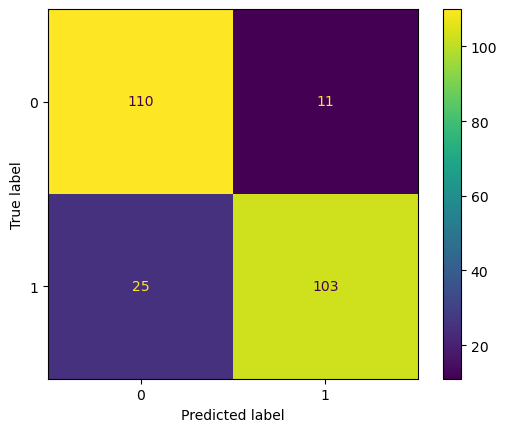

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Applying svm
# Creating the model
model = SVC(kernel='linear', random_state=400, C=2, gamma='scale', degree=5)
# Fitting the training data to the model
model.fit(x_train, y_train)
# Predict y
y_pred = model.predict(x_test)

# Checking the accuracies
print("Training Accuracy:", model.score(x_train, y_train))
print("Testing Accuracy:", model.score(x_test, y_test))

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()


## Creating and training svm-pca model

Training Accuracy: 0.9946452476572959
Testing Accuracy: 0.8554216867469879


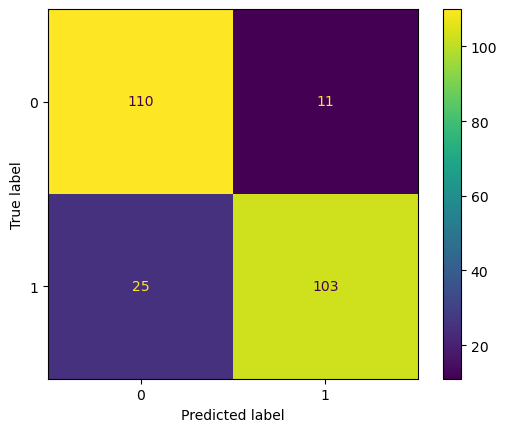

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

vectorizer = TfidfVectorizer()
rs = RobustScaler()
x = rs.fit_transform(x1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x = pca.fit_transform(x)
var = pca.explained_variance_ratio_

# Creating the model
model = SVC(kernel='linear', random_state=400, C=2, gamma='scale', degree=5)
# Fitting the training data to the model
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# Checking the accuracies
print("Training Accuracy:", model.score(x_train, y_train))
print("Testing Accuracy:", model.score(x_test, y_test))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
